In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline
from sklearn.cluster import DBSCAN
sns.set()
import time
import spacy
nlp = spacy.load('en_core_web_sm')
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


####### phase de collection des tweets #######

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()
# Configure
c = twint.Config()
#c.Username=""
c.Since = "2021-1-13"
c.Until = "2021-1-14"
c.Lang = "en"
c.Geo = "40.712784 ,-74.005941 ,1km"
c.Limit = 100
c.Output = "/Users/home/pfe/twitter_python/part_1_streaming_tweets/data/york1.json"
c.Store_json = True

# Run
twint.run.Search(c)

In [5]:
df=pd.read_json("/Users/home/pfe/twitter_python/part_1_streaming_tweets/data/york1.json",lines=True)

df.head()

,cashtags,conversation_id,created_at,date,geo,hashtags,id,language,likes_count,link,...,trans_dest,trans_src,translate,tweet,urls,user_id,user_rt,user_rt_id,username,video
0,[],1349454194563022848,"2021-01-13 21:32:06 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349454194563022850,en,0,https://twitter.com/LikkeJuan/status/134945419...,...,,,,Lysol - get 12 for $45 while supplies covid la...,[https://www.theparentgameblog.com/blog/lysol-...,20000088,,,likkejuan,0
1,[],1349453636762542080,"2021-01-13 21:29:53 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453636762542086,en,0,https://twitter.com/1sourcevideo/status/134945...,...,,,,"Just posted a photo @ New covid York, New York...",[https://www.instagram.com/p/CJ_6Uxnh-UV/?igsh...,60611392,,,1sourcevideo,0
2,[],1349453126156300288,"2021-01-13 21:27:51 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453126156300288,en,0,https://twitter.com/DopeVibe_Rocky/status/1349...,...,,,,"Just posted a photo @ New York, New York http...",[https://www.instagram.com/p/CJ_6GBpFe3u/?igsh...,43009235,,,dopevibe_rocky,0
3,[],1349452606310150144,"2021-01-13 21:25:47 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349452606310150145,en,0,https://twitter.com/TracyRingolsby/status/1349...,...,,,,Transfer Portal: Utah covid State Has 10 Playe...,[https://www.welcometo7220.com/around-the-mwc/...,126380866,,,tracyringolsby,0
4,[],1349451898047369216,"2021-01-13 21:22:58 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[flytographer],1349451898047369217,en,0,https://twitter.com/tomasauk/status/1349451898...,...,,,,"#Flytographer @dougjames74 @ New York,covid Ne...",[https://www.instagram.com/p/CJ_5iPhApTE/?igsh...,380230063,,,tomasauk,0


####### Prétraitement des tweets ######

In [6]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [7]:
# remove twitter handles (@user)
df['clean_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@*")
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df.head()

,cashtags,conversation_id,created_at,date,geo,hashtags,id,language,likes_count,link,...,trans_src,translate,tweet,urls,user_id,user_rt,user_rt_id,username,video,clean_tweet
0,[],1349454194563022848,"2021-01-13 21:32:06 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349454194563022850,en,0,https://twitter.com/LikkeJuan/status/134945419...,...,,,Lysol - get 12 for $45 while supplies covid la...,[https://www.theparentgameblog.com/blog/lysol-...,20000088,,,likkejuan,0,Lysol get for while supplies covid la...
1,[],1349453636762542080,"2021-01-13 21:29:53 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453636762542086,en,0,https://twitter.com/1sourcevideo/status/134945...,...,,,"Just posted a photo @ New covid York, New York...",[https://www.instagram.com/p/CJ_6Uxnh-UV/?igsh...,60611392,,,1sourcevideo,0,Just posted a photo New covid York New York ...
2,[],1349453126156300288,"2021-01-13 21:27:51 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453126156300288,en,0,https://twitter.com/DopeVibe_Rocky/status/1349...,...,,,"Just posted a photo @ New York, New York http...",[https://www.instagram.com/p/CJ_6GBpFe3u/?igsh...,43009235,,,dopevibe_rocky,0,Just posted a photo New York New York https...
3,[],1349452606310150144,"2021-01-13 21:25:47 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349452606310150145,en,0,https://twitter.com/TracyRingolsby/status/1349...,...,,,Transfer Portal: Utah covid State Has 10 Playe...,[https://www.welcometo7220.com/around-the-mwc/...,126380866,,,tracyringolsby,0,Transfer Portal Utah covid State Has Playe...
4,[],1349451898047369216,"2021-01-13 21:22:58 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[flytographer],1349451898047369217,en,0,https://twitter.com/tomasauk/status/1349451898...,...,,,"#Flytographer @dougjames74 @ New York,covid Ne...",[https://www.instagram.com/p/CJ_5iPhApTE/?igsh...,380230063,,,tomasauk,0,#Flytographer dougjames New York covid New ...


In [8]:
df["clean_date"]=''
s=''
for i in range (len(df)):
    
    df["clean_date"][i]=(re.sub("[^0-9]",str(s),str(df.date[i])))


In [9]:
df.head()

,cashtags,conversation_id,created_at,date,geo,hashtags,id,language,likes_count,link,...,translate,tweet,urls,user_id,user_rt,user_rt_id,username,video,clean_tweet,clean_date
0,[],1349454194563022848,"2021-01-13 21:32:06 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349454194563022850,en,0,https://twitter.com/LikkeJuan/status/134945419...,...,,Lysol - get 12 for $45 while supplies covid la...,[https://www.theparentgameblog.com/blog/lysol-...,20000088,,,likkejuan,0,Lysol get for while supplies covid la...,20210113000000
1,[],1349453636762542080,"2021-01-13 21:29:53 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453636762542086,en,0,https://twitter.com/1sourcevideo/status/134945...,...,,"Just posted a photo @ New covid York, New York...",[https://www.instagram.com/p/CJ_6Uxnh-UV/?igsh...,60611392,,,1sourcevideo,0,Just posted a photo New covid York New York ...,20210113000000
2,[],1349453126156300288,"2021-01-13 21:27:51 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453126156300288,en,0,https://twitter.com/DopeVibe_Rocky/status/1349...,...,,"Just posted a photo @ New York, New York http...",[https://www.instagram.com/p/CJ_6GBpFe3u/?igsh...,43009235,,,dopevibe_rocky,0,Just posted a photo New York New York https...,20210113000000
3,[],1349452606310150144,"2021-01-13 21:25:47 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349452606310150145,en,0,https://twitter.com/TracyRingolsby/status/1349...,...,,Transfer Portal: Utah covid State Has 10 Playe...,[https://www.welcometo7220.com/around-the-mwc/...,126380866,,,tracyringolsby,0,Transfer Portal Utah covid State Has Playe...,20210113000000
4,[],1349451898047369216,"2021-01-13 21:22:58 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[flytographer],1349451898047369217,en,0,https://twitter.com/tomasauk/status/1349451898...,...,,"#Flytographer @dougjames74 @ New York,covid Ne...",[https://www.instagram.com/p/CJ_5iPhApTE/?igsh...,380230063,,,tomasauk,0,#Flytographer dougjames New York covid New ...,20210113000000


In [10]:
chunk_name=[]
chunk_lieu=[]
df['chunk_lieu']=''
df['name_chunk']=''
def show_ents(doc): 
    for chunk in doc.noun_chunks:
        if chunk.root.dep_ in "pobj" :
            chunk_name.append(chunk.text)
        elif chunk.root.dep_ in "dobj":
            chunk_lieu.append(chunk.text)
    for token in doc.ents:
        if token.label_ in "PERSON" :
            chunk_name.append(token.text)
        elif token.label_ in "GPE" or "ORG":
            chunk_lieu.append(token.text)
            
         
    
    return chunk_lieu
    return chunk_name
def search(lieu):
    
    for i in range (len(df)):
        doc=nlp(df.clean_tweet[i])
        show_ents(doc)
        for j in range (len(chunk_name)):
            df.name_chunk[i]=chunk_name[j]
        for k in range(len(chunk_lieu)):
            df.chunk_lieu[i]=chunk_lieu[k]
        del chunk_name[:]
        del chunk_lieu[:]
        
search(df.clean_tweet)
df.head()

,cashtags,conversation_id,created_at,date,geo,hashtags,id,language,likes_count,link,...,urls,user_id,user_rt,user_rt_id,username,video,clean_tweet,clean_date,chunk_lieu,name_chunk
0,[],1349454194563022848,"2021-01-13 21:32:06 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349454194563022850,en,0,https://twitter.com/LikkeJuan/status/134945419...,...,[https://www.theparentgameblog.com/blog/lysol-...,20000088,,,likkejuan,0,Lysol get for while supplies covid la...,20210113000000,,
1,[],1349453636762542080,"2021-01-13 21:29:53 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453636762542086,en,0,https://twitter.com/1sourcevideo/status/134945...,...,[https://www.instagram.com/p/CJ_6Uxnh-UV/?igsh...,60611392,,,1sourcevideo,0,Just posted a photo New covid York New York ...,20210113000000,New York,
2,[],1349453126156300288,"2021-01-13 21:27:51 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453126156300288,en,0,https://twitter.com/DopeVibe_Rocky/status/1349...,...,[https://www.instagram.com/p/CJ_6GBpFe3u/?igsh...,43009235,,,dopevibe_rocky,0,Just posted a photo New York New York https...,20210113000000,New York,
3,[],1349452606310150144,"2021-01-13 21:25:47 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349452606310150145,en,0,https://twitter.com/TracyRingolsby/status/1349...,...,[https://www.welcometo7220.com/around-the-mwc/...,126380866,,,tracyringolsby,0,Transfer Portal Utah covid State Has Playe...,20210113000000,rWcK,New Home
4,[],1349451898047369216,"2021-01-13 21:22:58 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[flytographer],1349451898047369217,en,0,https://twitter.com/tomasauk/status/1349451898...,...,[https://www.instagram.com/p/CJ_5iPhApTE/?igsh...,380230063,,,tomasauk,0,#Flytographer dougjames New York covid New ...,20210113000000,New York,


######## Extraction des rencontres#########

In [11]:
places=[]
a=''
df['rencontre']=a
#df['suspect']=a
df['find_from']=a
#df['counte']='0'
df['pourcentage']='0'
c=0
for i in range(len(df)):
    c=0
    for j in range(len(df)):
        if i!=j :
            if (str(df.username[j]) in str(df.name_chunk[i])):
                df['rencontre'][i]=df.name[j]
                df['find_from'][i]="mention_name"
                df['pourcentage'][i]=70
            elif len(df.mentions[i])!=0:
                df['rencontre'][i]=df.mentions[i][0]['name']
                df['find_from'][i]="mention_name"
                df['pourcentage'][i]=50
            elif (str(df.date[j]) in str(df.date[i])) and (str(df.chunk_lieu[i]) in str(df.chunk_lieu[j])):
                df['rencontre'][i]=df.name[j] 
                df['find_from'][i]="tweets_place"
                df['pourcentage'][i]=25
            elif (str(df.date[j]) in str(df.date[i])) and (str(df.place[i]) in str(df.place[j])):
                df['rencontre'][i]=df.name[j]
                df['find_from'][i]="place"
                df['pourcentage'][i]=40
                    
                
                c=c+1
                #df['counte'][i]=c
#for i in range (len(df.meet)):
    #if (str(df.username[i]) in affected):            
        #df['suspect'][i]=df.meet[i]



In [12]:
df.head()

,cashtags,conversation_id,created_at,date,geo,hashtags,id,language,likes_count,link,...,user_rt_id,username,video,clean_tweet,clean_date,chunk_lieu,name_chunk,rencontre,find_from,pourcentage
0,[],1349454194563022848,"2021-01-13 21:32:06 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349454194563022850,en,0,https://twitter.com/LikkeJuan/status/134945419...,...,,likkejuan,0,Lysol get for while supplies covid la...,20210113000000,,,Yoneiry,tweets_place,25
1,[],1349453636762542080,"2021-01-13 21:29:53 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453636762542086,en,0,https://twitter.com/1sourcevideo/status/134945...,...,,1sourcevideo,0,Just posted a photo New covid York New York ...,20210113000000,New York,,Yoneiry,tweets_place,25
2,[],1349453126156300288,"2021-01-13 21:27:51 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349453126156300288,en,0,https://twitter.com/DopeVibe_Rocky/status/1349...,...,,dopevibe_rocky,0,Just posted a photo New York New York https...,20210113000000,New York,,Yoneiry,tweets_place,25
3,[],1349452606310150144,"2021-01-13 21:25:47 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[],1349452606310150145,en,0,https://twitter.com/TracyRingolsby/status/1349...,...,,tracyringolsby,0,Transfer Portal Utah covid State Has Playe...,20210113000000,rWcK,New Home,Jillyclaire GFE - Milf next door ðŸŒ¸,place,40
4,[],1349451898047369216,"2021-01-13 21:22:58 Paris, Madrid",2021-01-13,"40.712784,-74.005941,1km",[flytographer],1349451898047369217,en,0,https://twitter.com/tomasauk/status/1349451898...,...,,tomasauk,0,#Flytographer dougjames New York covid New ...,20210113000000,New York,,Yoneiry,tweets_place,25


In [13]:
import random
s=len(df)
k=int((s*20)/100)

print(k)
tester_pos=[]
for i in range(k) :
    tester_pos.append(random.choice(df.name))

tester_pos

10


['ðŸ’™ðŸ…¶ðŸ†„ðŸ…½ðŸ…½ðŸ…°*ðŸ†‰ ðŸ‡ºðŸ‡¸',
 'Jillyclaire GFE - Milf next door ðŸŒ¸',
 'Toma Sauk',
 'Specky Scribbler | Michelle',
 'Elizabeth',
 'Don_tbone ðŸ‡µðŸ‡·ðŸ‡µðŸ‡·ðŸ‡µðŸ‡·',
 '20thCenturyGeek_Pod',
 'Downtown Magazine NY #myviewdowntown',
 'Elizabeth',
 'Yoneiry']

In [14]:
b=''
s=[]
a=[]
pos=[]
aa=[]
ss=[]
prc=[]
date_r=[]
find=[]
for i in range(len(df)):
    if df.rencontre[i] is not b   :
        s.append(df.rencontre[i])
        a.append(df.name[i])
        prc.append(df.pourcentage[i])
        tester_pos.append(b)
        date_r.append(df.clean_date[i])
        find.append(df.find_from[i])
        #pos.append(df.suspect[i])

        

In [15]:
import seaborn as sns
sns.set(color_codes=True)

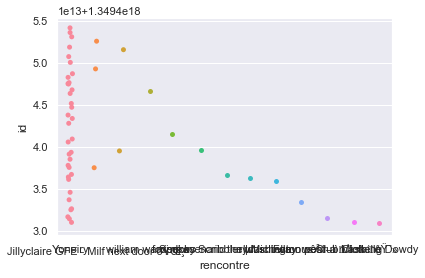

In [16]:
sns.stripplot(df["rencontre"],df["id"])

In [17]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [18]:
import plotly.io as pio
pio.renderers.default = 'browser'

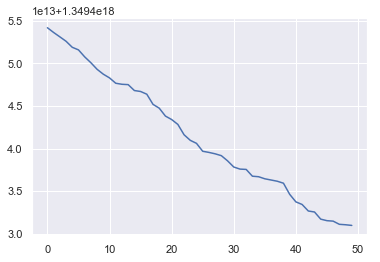

In [19]:
df["id"].plot()

########## Génération du graph Neo4j #############################

In [20]:
from py2neo import Graph, Node, Relationship
import os
import sys
import time
import requests

In [21]:
from neo4j import GraphDatabase
driver=GraphDatabase.driver(uri= "bolt://localhost:7687",auth=("neo4j","pfe"))
session=driver.session()
from py2neo import Graph,Node,Relationship
graph = Graph("bolt://localhost:7687", auth=("neo4j", "pfe"))
graph.delete_all()

In [22]:

q1="""
MERGE(A:POSITIF{positif_name:$positif_name})
MERGE(B:SAFE_P{safe_name:$safe_name})
MERGE(C:SUSPECT_P{suspect_p:$suspect_p,pourcentage:$pourcentage})
MERGE (A)-[:MEET{on_date:$dat,find:$find}]->(C)
MERGE (B)-[:MEET{on_date:$dat}]->(C)
"""


In [23]:

for i in range(len(s)):
        p={"suspect_p":s[i],"date_place":df.find_from[i],"positif_name":tester_pos[i],"safe_name":a[i],"pourcentage":prc[i],"dat":date_r[i],"find":find[i]}
        session.run(q1,p)


############## identification des cas suspect######

In [24]:
q2="""
match(p:POSITIF)
where p.positif_name=''
detach delete p
"""

q3="""
MATCH (p:POSITIF),(s:SUSPECT_P),(n:SAFE_P)
WHERE p.positif_name = s.suspect_name and p.positif_name = n.safe_name
 
detach DELETE n
"""
q4="""
MATCH (p:POSITIF),(s:SUSPECT_P),(n:SAFE_P)
WHERE p.positif_name = s.suspect_name and p.positif_name = n.safe_name
 
detach DELETE s
"""


In [25]:
session.run(q2,p)

In [26]:
session.run(q3,p)

In [27]:
session.run(q4,p)

In [28]:
q5="""
match(s:SUSPECT_P)
return s as suspect_list
"""


In [29]:
resultat=session.run(q5)
resultat

In [30]:
data=data=resultat.data()
susp=pd.DataFrame(data)

In [31]:
susp

,suspect_list
0,"{'suspect_p': 'Yoneiry', 'pourcentage': 25}"
1,{'suspect_p': 'Jillyclaire GFE - Milf next doo...
2,"{'suspect_p': 'Yoneiry', 'pourcentage': 40}"
3,"{'suspect_p': 'william warnecke', 'pourcentage..."
4,"{'suspect_p': 'fox news', 'pourcentage': 50}"
5,"{'suspect_p': 'dj scenario', 'pourcentage': 50}"
6,"{'suspect_p': 'Specky Scribbler | Michelle', '..."
7,"{'suspect_p': 'lulu', 'pourcentage': 50}"
8,"{'suspect_p': 'the washington post', 'pourcent..."
9,"{'suspect_p': 'nyct subway. wear a mask.', 'po..."


In [ ]:
susp